# <span style="color:red"> Laboratorio di Simulazione Numerica (NSL) </span>
## <span style="color:blue">  Esercitazione 4</span>

In questa esercitazione andremo ad effettuare delle simulazioni di *Dinamica Molecolare* (***MD***) per un modello *Lennard-Jones* dell'Argon $Ar$ nella fase solida, liquida e gassosa. Sulla base di queste simulazioni produrremo delle stime dei valori di energia e temperatura.

### Esercizio 04.1 - 04.2

Il codice con cui effettiuamo le simulazioni è ``MolDyn_NVE``; si tratta di un codice deterministico, che sfrutta l'*algoritmo di Verlet* per integrare le equazioni del moto per un sistema di $N_{part}$ particelle.
Questo codice opera le simulazioni in un ensemble *microcanonico* (***NVE***), in cui l'energia totale $E$ è fissata.

Inoltre, sono implementate le *condizioni periodiche al contorno* (***PBC***), per replicare il box in cui svolge la simulazione indefinitamente nello spazio.

Tutte le simulazioni che svolgiamo utilizzano *unità di Lennard-Jones* ($LJ$): scegliendo una unità conveniente per la massa, la lunghezza e l'energia, tutte le altre unità si riducono in forma adimensionale e le grandezze assumono valori facilmente gestibili a livello computazionale. Chiamiamo la terna di unità $LJ$ $(m,\sigma,\epsilon)$.

Il programma prende come valori in input le seguenti quantità (indichiamo con * le grandezze espresse in unità ridotte):

- Temperatura  $\:\:\:T^*=\dfrac{k_bT}{\epsilon}$
- Densità $\:\:\:\rho^*=\rho\sigma^3$
- Numero di particelle del sistema $\:\:\:N_{part}$
- Numero di step temporali della simulazione $\:\:\:N_{step}$
- Raggio di cut-off $\:\:\:r_c$
- Intervallo di tempo per l'integrazione numerica $\:\:\:dt$

Serve inoltre specificare $n_{measure}$, un numero che ci dice ogni quante volte si effettua una misura del sistema rispetto al numero totale di integrazioni; è importante scelgiere questo numero nè troppo grande, né troppo piccolo, in modo da evitare che le misure siano troppo ravvicinate o troppo lontane tra le configurazioni del sistema.

Il programma legge dal file ``config.0`` la configurazione attuale del sistema e dal file ``old.0`` la configurazione precedente, necessarie per avviare l'algoritmo di Verlet. Se il file ``old.0`` non è presente (ad esempio quando facciamo partire la simulazione da zero) il codice genera una configurazione ex-novo attraverso un campionamento casuale delle velocità.

Prima avviare le simulazioni con cui andremo a produrre le stime delle quantità che ci interessano, dobbiamo equilibrare il sistema. Siamo infatti interessati a studiare le proprietà del sistema ad una determinata temperatura. Tuttavia lasciando evolvere il sistema, si vede come la temperatura non rimane localizzata attorno al valore fornito in input (siamo nell'insieme ***NVE***) ma appena il sistema evolve, crolla o risale rapidamente a valori diversi, su cui si stabilizza (come mostrato nel grafico successivo).

Al fine di far partire la simulazione col giusto valore di temperatura, vogliamo equilibrare il sistema; per fare questo andiamo ad inserire un riscalamento delle velocità all'inizio di ogni simulazione, a partire dalle temperature:

$$
\lambda_{scaling} = \sqrt{\frac{T*}{T}}
$$

dove $T*$ è la temperatura target e $T$ la temperatura attuale del sistema. Una volte ottenute le nuove velocità riscalate, andiamo a calcolare la nuova configurazione precedente, con cui facciamo partire la simulazione; dopo un numero di step sufficente, questa si arresta e sovrascrive le nuove poszioni finali nei due file citati sopra., in modo da potere fare ripartire la simulazione dall'ultima configurazione.

Questo procedimento è ripetuto più volte, finchè la simulazione non raggiunge il valore di temperatura desiderato. A quel punto, si interrompe il processo di riscalamento e il programma può essere utilizzato per fare partire la simulazione da cui vogliamo stimare le quantità di interesse.

Di seguito è riportato un esempio di equilibrazione; ogni simulazione per l'equlibrazione conta di $10^4$ step; il sistema raggiunge la temperatura target dopo circa $6$ simulazioni. 

In [1]:
# Modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

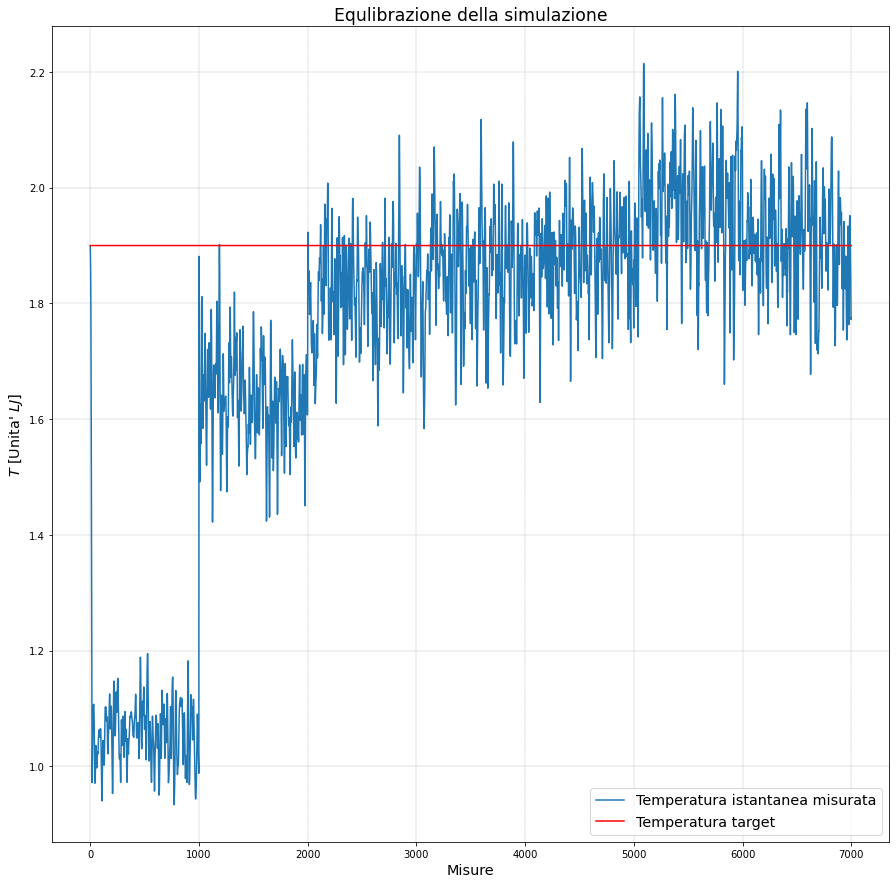

In [11]:
#Showing stabilizazion of the the system

fig1, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(15,15))

n_blocks = 7000
T = 1.9

x = np.arange(n_blocks)

temp = np.zeros(n_blocks)

file_temp_stab = open("MolDyn_Improved/Data/output_temp.dat")
temp = np.loadtxt(file_temp_stab, unpack = True)
           
file_temp_stab.close()

expected = [T for i in x]


ax0.plot(x,temp, label="Temperatura istantanea misurata")
ax0.plot(x,expected, color="r", label="Temperatura target")
ax0.set_xlabel('Misure', fontsize='x-large')
ax0.set_ylabel(r"$T$ [Unita' $LJ$]", fontsize='x-large')
ax0.set_title("Equlibrazione della simulazione", fontsize='xx-large')
ax0.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)
ax0.legend(loc="lower right", fontsize="x-large")

plt.show()

Nelle simulazioni, per produrre le stime delle grandezze di interesse, sfurtteremo il *data blocking* gli $N_{step}$ della simulazione sono suddivisi in $N_{block}$ blocchi, in cui calcoliamo valore medio ed incertezza statistica che non presenteranno correlazioni se i blocchi sono sufficentemente grandi.

### Esercizio 04.3
Le grandezze che vogliamo misurare sono l'energia interna per particella $U/N$, l'energia cinetica per particella $K/N$, l'energia totale per particella $E/N$ e la temperatura $T$.

Le unità $LJ$ per l'argon sono:

- $\sigma = 0.34\:nm$
- $\dfrac{\epsilon}{K_b}=120\: K$ 
- $m=39.948 \:amu$

I parametri dell'argon nelle 3 fasi sono i seguenti:

1. Fase solida: $\rho^\star = 1.1$, $\:T^\star = 0.8$, $\:r_c = 2.2$
2. Fase liquida: $\rho^\star = 0.8$, $\:T^\star = 1.1$, $\:r_c = 2.5$
3. Fase gassosa: $\rho^\star = 0.05$, $\:T^\star = 1.2$, $\:r_c = 5.0$

Il sistema simulato è composto da $108$ particelle, che assumiamo avere massa unitaria; ogni simulazione conta $10^5$ step divisi in $100$ blocchi. Le misure sono effettuate ogni $10$ step ($n_{measure}=10$).

La configurazione iniziale del sistema è un reticolo cubico a facce centrate (*FCC*), la configurazione precedente è generata campioando in modo casuale le velocità, da cui si parte per i passaggi di equilibrazione: le fasi solida e liquida hanno richiesto $5$ passaggi per l'equilibrazione; la fase gassosa ha richiesto $9$ passaggi. 

Di seguito sono riportate le stime delle grandezze misurate, in funzione del numero dei blocchi, in unità $SI$.

In [3]:
#LJ units for Argon
sigma = 0.34e-9
Kb=8.617333262145e-5 #ev
epsilon = 120*Kb    #K*eV
m = 39.948*1.66054e-27 #amu

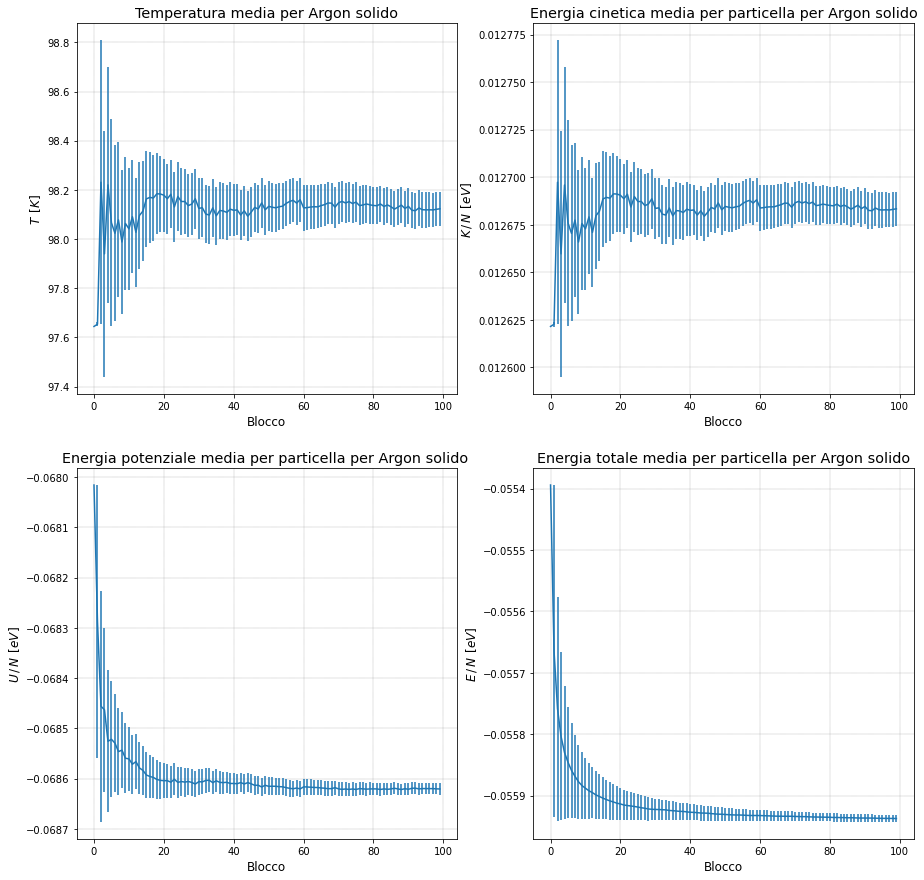

In [13]:
#Argon Solid Phase

fig2, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

n_blocks = 100
x = np.arange(n_blocks)

temp = np.zeros(n_blocks)
ekin = np.zeros(n_blocks)
epot = np.zeros(n_blocks)
etot = np.zeros(n_blocks)

temp_err = np.zeros(n_blocks)
ekin_err = np.zeros(n_blocks)
epot_err = np.zeros(n_blocks)
etot_err = np.zeros(n_blocks)

file_temp = open("Argon_solid/Data/ave_temp.out")
file_ekin = open("Argon_solid/Data/ave_ekin.out")
file_epot = open("Argon_solid/Data/ave_epot.out")
file_etot = open("Argon_solid/Data/ave_etot.out")

temp, temp_err = np.loadtxt(file_temp, unpack=True)
ekin, ekin_err = np.loadtxt(file_ekin, unpack=True)
epot, epot_err = np.loadtxt(file_epot, unpack=True)
etot, etot_err = np.loadtxt(file_etot, unpack=True)
    
file_temp.close()
file_ekin.close()
file_epot.close()
file_etot.close()

#Data in SI units

temp*=epsilon/Kb
temp_err*=epsilon/Kb

ekin*=epsilon
ekin_err*=epsilon

epot*=epsilon
epot_err*=epsilon

etot*=epsilon
etot_err*=epsilon

#Temperature
ax0.errorbar(x,temp,yerr=temp_err)
ax0.set_xlabel('Blocco', fontsize='large')
ax0.set_ylabel('$T \:\: [K]$', fontsize='large')
ax0.set_title('Temperatura media per Argon solido', fontsize='x-large')
ax0.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Kin
ax1.errorbar(x,ekin,yerr=ekin_err)
ax1.set_xlabel('Blocco', fontsize='large')
ax1.set_ylabel('$K\, /\, N \:\:[eV]$', fontsize='large')
ax1.set_title('Energia cinetica media per particella per Argon solido', fontsize='x-large')
ax1.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Pot
ax2.errorbar(x,epot,yerr=epot_err)
ax2.set_xlabel('Blocco', fontsize='large')
ax2.set_ylabel('$U\,/\,N \:\:[eV]$', fontsize='large')
ax2.set_title('Energia potenziale media per particella per Argon solido ', fontsize='x-large')
ax2.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Tot
ax3.errorbar(x,etot,yerr=etot_err)
ax3.set_xlabel('Blocco', fontsize='large')
ax3.set_ylabel('$E\,/\,N \:\:[eV]$', fontsize='large')
ax3.set_title('Energia totale media per particella per Argon solido', fontsize='x-large')
ax3.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

plt.show()

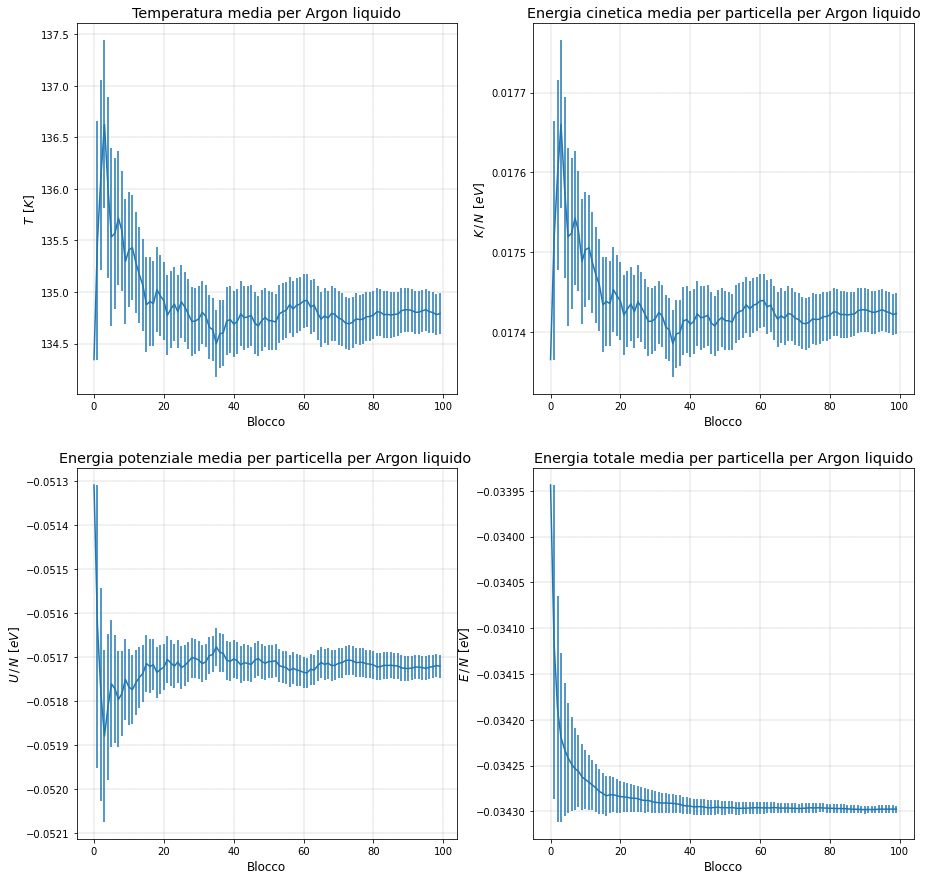

In [14]:
#Argon liquid Phase

fig2, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

n_blocks = 100
x = np.arange(n_blocks)

temp = np.zeros(n_blocks)
ekin = np.zeros(n_blocks)
epot = np.zeros(n_blocks)
etot = np.zeros(n_blocks)

temp_err = np.zeros(n_blocks)
ekin_err = np.zeros(n_blocks)
epot_err = np.zeros(n_blocks)
etot_err = np.zeros(n_blocks)

file_temp = open("Argon_liquid/Data/ave_temp.out")
file_ekin = open("Argon_liquid/Data/ave_ekin.out")
file_epot = open("Argon_liquid/Data/ave_epot.out")
file_etot = open("Argon_liquid/Data/ave_etot.out")

temp, temp_err = np.loadtxt(file_temp, unpack=True)
ekin, ekin_err = np.loadtxt(file_ekin, unpack=True)
epot, epot_err = np.loadtxt(file_epot, unpack=True)
etot, etot_err = np.loadtxt(file_etot, unpack=True)
    
file_temp.close()
file_ekin.close()
file_epot.close()
file_etot.close()

#Data in SI units

temp*=epsilon/Kb
temp_err*=epsilon/Kb

ekin*=epsilon
ekin_err*=epsilon

epot*=epsilon
epot_err*=epsilon

etot*=epsilon
etot_err*=epsilon

#Temperature
ax0.errorbar(x,temp,yerr=temp_err)
ax0.set_xlabel('Blocco', fontsize='large')
ax0.set_ylabel('$T \:\: [K]$', fontsize='large')
ax0.set_title('Temperatura media per Argon liquido', fontsize='x-large')
ax0.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Kin
ax1.errorbar(x,ekin,yerr=ekin_err)
ax1.set_xlabel('Blocco', fontsize='large')
ax1.set_ylabel('$K\, /\, N \:\:[eV]$', fontsize='large')
ax1.set_title('Energia cinetica media per particella per Argon liquido', fontsize='x-large')
ax1.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Pot
ax2.errorbar(x,epot,yerr=epot_err)
ax2.set_xlabel('Blocco', fontsize='large')
ax2.set_ylabel('$U\,/\,N \:\:[eV]$', fontsize='large')
ax2.set_title('Energia potenziale media per particella per Argon liquido ', fontsize='x-large')
ax2.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Tot
ax3.errorbar(x,etot,yerr=etot_err)
ax3.set_xlabel('Blocco', fontsize='large')
ax3.set_ylabel('$E\,/\,N \:\:[eV]$', fontsize='large')
ax3.set_title('Energia totale media per particella per Argon liquido', fontsize='x-large')
ax3.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

plt.show()

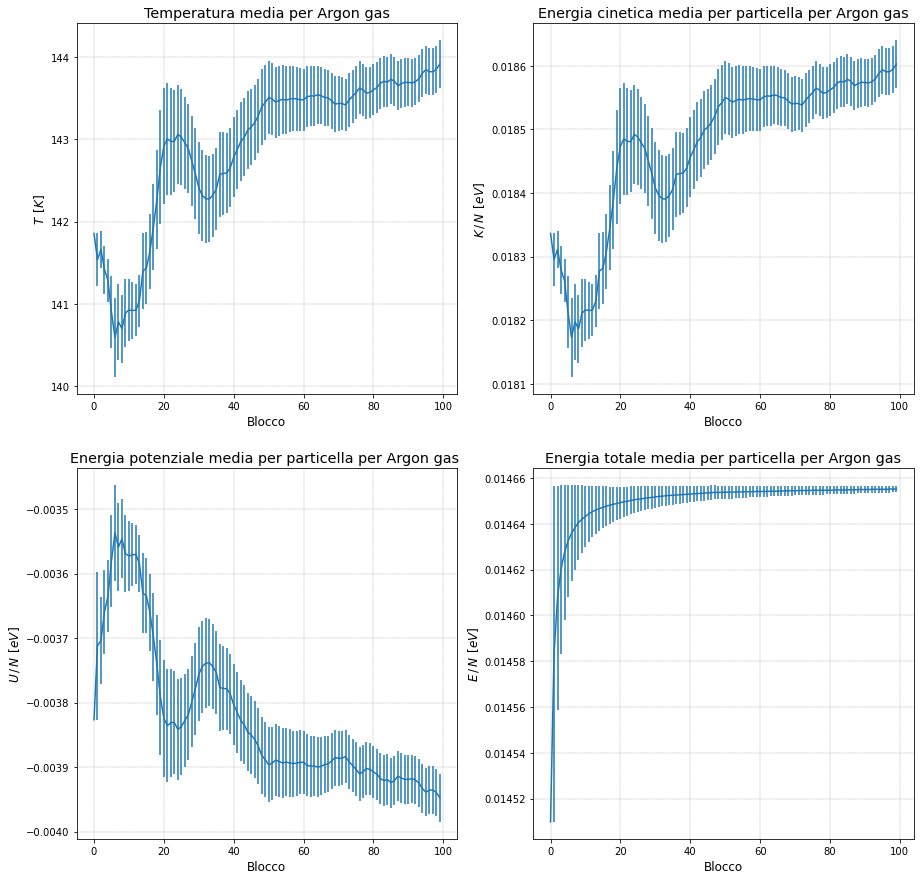

In [17]:
#Argon gas Phase

fig2, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

n_blocks = 100
x = np.arange(n_blocks)

temp = np.zeros(n_blocks)
ekin = np.zeros(n_blocks)
epot = np.zeros(n_blocks)
etot = np.zeros(n_blocks)

temp_err = np.zeros(n_blocks)
ekin_err = np.zeros(n_blocks)
epot_err = np.zeros(n_blocks)
etot_err = np.zeros(n_blocks)

file_temp = open("Argon_gas/Data/ave_temp.out")
file_ekin = open("Argon_gas/Data/ave_ekin.out")
file_epot = open("Argon_gas/Data/ave_epot.out")
file_etot = open("Argon_gas/Data/ave_etot.out")

temp, temp_err = np.loadtxt(file_temp, unpack=True)
ekin, ekin_err = np.loadtxt(file_ekin, unpack=True)
epot, epot_err = np.loadtxt(file_epot, unpack=True)
etot, etot_err = np.loadtxt(file_etot, unpack=True)
    
file_temp.close()
file_ekin.close()
file_epot.close()
file_etot.close()

#Data in SI units

temp*=epsilon/Kb
temp_err*=epsilon/Kb

ekin*=epsilon
ekin_err*=epsilon

epot*=epsilon
epot_err*=epsilon

etot*=epsilon
etot_err*=epsilon

#Temperature
ax0.errorbar(x,temp,yerr=temp_err)
ax0.set_xlabel('Blocco', fontsize='large')
ax0.set_ylabel('$T \:\: [K]$', fontsize='large')
ax0.set_title('Temperatura media per Argon gas', fontsize='x-large')
ax0.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Kin
ax1.errorbar(x,ekin,yerr=ekin_err)
ax1.set_xlabel('Blocco', fontsize='large')
ax1.set_ylabel('$K\, /\, N \:\:[eV]$', fontsize='large')
ax1.set_title('Energia cinetica media per particella per Argon gas', fontsize='x-large')
ax1.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Pot
ax2.errorbar(x,epot,yerr=epot_err)
ax2.set_xlabel('Blocco', fontsize='large')
ax2.set_ylabel('$U\,/\,N \:\:[eV]$', fontsize='large')
ax2.set_title('Energia potenziale media per particella per Argon gas ', fontsize='x-large')
ax2.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

#E Tot
ax3.errorbar(x,etot,yerr=etot_err)
ax3.set_xlabel('Blocco', fontsize='large')
ax3.set_ylabel('$E\,/\,N \:\:[eV]$', fontsize='large')
ax3.set_title('Energia totale media per particella per Argon gas', fontsize='x-large')
ax3.grid(True, linestyle="--", linewidth=0.2, color='.25', zorder=-10)

plt.show()

Alcune osservazioni:

- In tutte le simulazioni, $E$ raggiunge rapidamente un valore medio costante, con fluttuazioni pressochè nulle; questo è in accordo con il fatto che la simulazione opera nell'insieme microcanonico, ad energia fissata.
- Le grandezze misurate per la fase solida e liquida presentano un buon comportamento: convergono ad un valore stabile, con piu fluttuazioni nel caso del liquido; le grandezze misurate per la fase gassosa sono invece molto più irregolari, con grandi fluttuazioni. E' possibile rincondurre questo comportamento alle proprietà fisiche della fase gassosa (bassa densità, alta temperatura...) che rendono questo sistema più difficile da simulare con questo codice.
- Gli andamenti di temperatura ed energia cinetica sono presssochè identici; in effetti, le due grandezze differiscono solo per un fattore numerico.